In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs

from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset
                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k

from geo_tool import Point_Cloud

from tf_lab.nips.data_sets.shape_net import pc_loader as sn_pc_loader
from tf_lab.point_clouds.raw_gan import RawGAN
from tf_lab.point_clouds.raw_gan_gp import RawGAN_GP
from tf_lab.point_clouds.latent_gan import LatentGAN
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.point_net_aae import PointNetAdversarialAutoEncoder


from tf_lab.nips.evaluate_gan import entropy_of_occupancy_grid, jensen_shannon_divergence, \
                                     sample_pclouds_distances

from tf_lab.point_clouds.gan import model_saver_id

from tf_lab.autopredictors.exploration import find_neighbors

from tf_lab.nips.helper import pclouds_centered_and_half_sphere

from tf_lab.point_clouds.generators_discriminators import latent_code_discriminator_two_layers, latent_code_generator_two_layers    

from tf_lab.icml.ae_farm_helper import relevant_class

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
class_name = raw_input('Give me the class type: ').lower()
n_pc_samples = 2048
do_training = True
load_model = True
load_epoch = None
saver_step = 10
ae_loss = 'emd'

syn_id = shape_net_category_to_synth_id()[class_name]
bneck_size = int(raw_input('Give me the AE bneck size:'))

experiment_name = 'aee_' + class_name + '_conv_arch_bneck_' + str(bneck_size) + '_2048pts_' + ae_loss
train_dir = osp.join(top_data_dir, 'OUT/models/nips/adversarial_ae', experiment_name)
create_dir(train_dir)

# save_synthetic_samples = True
# synthetic_data_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/synthetic_point_clouds'

Give me the class type: chair
Give me the AE bneck size:32


'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/adversarial_ae/aee_chair_conv_arch_bneck_32_2048pts_emd'

In [8]:
# Load Raw Point-Clouds of class
pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
pclouds_path = osp.join(pclouds_path, syn_id)
file_names = pio.load_filenames_of_input_data(pclouds_path, '.ply')
pclouds, model_ids, syn_ids = pio.load_crude_point_clouds(file_names=file_names, n_threads=50, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(pclouds), )
train_data = PointCloudDataSet(pclouds)

6778 files containing complete point clouds were found.


In [15]:
if load_model:
    conf = Conf.load(osp.join(train_dir, 'configuration'))
    print conf
else:    
    n_input = [n_pc_samples, 3]
    decoder_args = {'layer_sizes': [1024, 2048, np.prod(n_input)] }
    encoder_args = {'n_filters': [128, 128, 256, bneck_size],
                    'filter_sizes': [40, 20, 10, 10],
                    'strides': [1, 2, 2, 1]}
    conf = Conf(
                n_input = n_input,
                training_epochs = 1000,
                batch_size = 50,
                loss = ae_loss,
                denoising = False,
                train_dir = train_dir,
                loss_display_step = 1,
                saver_step = saver_step,
                learning_rate = 0.0005,
                z_rotate = False,
                encoder = enc_dec.encoder_with_convs_and_symmetry,
                encoder_args = encoder_args,
                decoder = enc_dec.decoder_with_fc_only,
                decoder_args = decoder_args,        
               )

    conf.lr_adv = 0.00001
    conf.beta_adv = 0

    conf.experiment_name = experiment_name
    conf.save(osp.join(conf.train_dir, 'configuration'))

                    batch_size: 50
                      beta_adv: 0
                 consistent_io: None
                         debug: False
                       decoder: decoder_with_fc_only
                  decoder_args: {'layer_sizes': [1024, 2048, 6144]}
                       encoder: encoder_with_convs_and_symmetry
                  encoder_args: {'filter_sizes': [40, 20, 10, 10], 'n_filters': [128, 128, 256, 32], 'strides': [1, 2, 2, 1]}
               experiment_name: aee_chair_conv_arch_bneck_32_2048pts_emd
                 gauss_augment: None
                  is_denoising: False
               latent_vs_recon: 1.0
                 learning_rate: 0.0005
                          loss: emd
             loss_display_step: 1
                        lr_adv: 1e-05
                       n_input: [2048, 3]
                      n_output: [2048, 3]
                           n_z: None
             saver_max_to_keep: None
                    saver_step: 10
                     

In [18]:
discriminator = latent_code_discriminator_two_layers
noise_dim = bneck_size
reset_tf_graph()
aae = PointNetAdversarialAutoEncoder(experiment_name, conf, noise_dim, discriminator)

if load_model:
    if load_epoch is None: # load last saved.
        saved_epochs = read_saved_epochs(conf.train_dir)
        load_epoch = saved_epochs[-1]
        
    aae.restore_model(conf.train_dir, load_epoch, verbose=True)

Model restored in epoch 110.


In [19]:
if do_training:
#     buf_size = 1 # flush each line
#     fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
    train_stats = aae.train(train_data, conf)
#     fout.close()

('Epoch:', '0111', 'training time (minutes)=', '0.5742', 'loss', array([  7.26401601e+01,   2.09622814e-03,   7.86090985e+00]))
('Epoch:', '0112', 'training time (minutes)=', '0.5331', 'loss', array([  7.23128121e+01,   1.37847436e-03,   7.92691992e+00]))
('Epoch:', '0113', 'training time (minutes)=', '0.5377', 'loss', array([  7.21101569e+01,   1.55802017e-03,   7.88882585e+00]))
('Epoch:', '0114', 'training time (minutes)=', '0.5430', 'loss', array([  7.21898231e+01,   1.56379755e-03,   7.97942356e+00]))
('Epoch:', '0115', 'training time (minutes)=', '0.5368', 'loss', array([  7.20332450e+01,   1.81526977e-03,   7.89081039e+00]))
('Epoch:', '0116', 'training time (minutes)=', '0.5396', 'loss', array([  7.15603104e+01,   1.66587252e-03,   7.84623375e+00]))
('Epoch:', '0117', 'training time (minutes)=', '0.5396', 'loss', array([  7.17939712e+01,   1.61552447e-03,   7.93501907e+00]))
('Epoch:', '0118', 'training time (minutes)=', '0.5377', 'loss', array([  7.14416677e+01,   1.69798164e-

In [20]:
feed = train_data.next_batch(10)[0]
aae.loss = aae.structural_loss
rec = aae.reconstruct(feed)[0]

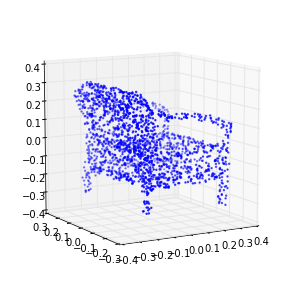

In [23]:
Point_Cloud(rec[2]).plot();